In [1]:
from astropy.io import fits

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.15'

jax.config.update("jax_enable_x64", True)

## Processing Fits File

In [2]:
def process_image(image, scale_factor=1, offset=1):
    scaled_image = (image[::scale_factor, ::scale_factor])[1::, 1::]
    cropped_image = image[70:210, 70:210]
    def safe_float32_conversion(value):
        try:
            return np.float32(value)
        except (ValueError, TypeError):
            print("This value is unjaxable: " + str(value))
    fin_image = np.nan_to_num(cropped_image)
    fin_image = np.vectorize(safe_float32_conversion)(fin_image)
    return fin_image

Filename: Fits/hd157587_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     459   ()      
  1  SCI           1 ImageHDU       138   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


Text(0.5, 1.0, 'Image from Fits File')

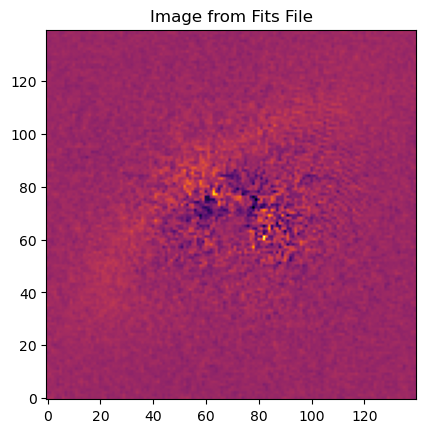

In [3]:
fits_image_filepath = "Fits/hd157587_H_pol.fits"
hdul = fits.open(fits_image_filepath)

#Displays File Info
hdul.info()

# Gets Image
target_image = process_image(hdul['SCI'].data[1,:,:])

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")

## Getting Optimal Disk Fit

In [4]:
from optimize import quick_optimize_cent
from optimize import quick_image_cent
from disk_utils_jax import jax_model_all_1d
from regression import log_likelihood_1d_pos_all_pars_spline
from scipy.optimize import minimize
from SLD_utils import *

### Generating Error Map

In [5]:
# Creating error map
def create_circular_err_map(image_shape, iradius, oradius, noise_level):
    err_map = jnp.zeros(image_shape)
    center = image_shape[0]/2
    y, x = jnp.ogrid[:image_shape[0], :image_shape[1]]
    distance = jnp.sqrt((x - center) ** 2 + (y - center) ** 2)  
    err_map = jnp.where(distance <= oradius, noise_level, 1e8)
    err_map = jnp.where(distance >= iradius, err_map, 1e8)
    return err_map

err_map = create_circular_err_map(target_image.shape, 12, 83, 15)

### Getting Optimal Fit

In [6]:
target_image = jnp.asarray(target_image)

soln = quick_optimize_cent(target_image, err_map, method = None, iters = 2000, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)
print(soln)

# soln is an array of all the optimal parameters
# 0: x position of center, 1: y position of center, 2: alpha_in, 3: alpha_out, 4: sma, 5: inclination, 6: position_angle, (7-12): y positions of spf spline knots (linspace(1,-1,6)) 

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 80520.64765006011
        x: [ 6.771e+01  6.923e+01 ...  2.704e-04  4.564e-04]
      nit: 207
      jac: [ 9.766e-04 -9.766e-04 ...  1.085e+01  6.755e+00]
 hess_inv: [[ 5.663e-01 -1.607e-01 ...  5.427e-06  8.421e-06]
            [-1.607e-01  1.951e-01 ... -2.666e-06 -2.170e-06]
            ...
            [ 5.427e-06 -2.666e-06 ...  2.832e-10 -1.607e-11]
            [ 8.421e-06 -2.170e-06 ... -1.607e-11  1.292e-09]]
     nfev: 3990
     njev: 285
[ 6.77075675e+01  6.92312707e+01  9.41757859e+00 -2.60785604e+00
  5.42302072e+01  7.04549744e+01 -5.19489857e+01  3.39157126e-05
  7.62666962e-05  1.54914219e-04  2.41760181e-04  2.70367545e-04
  4.56403315e-04]


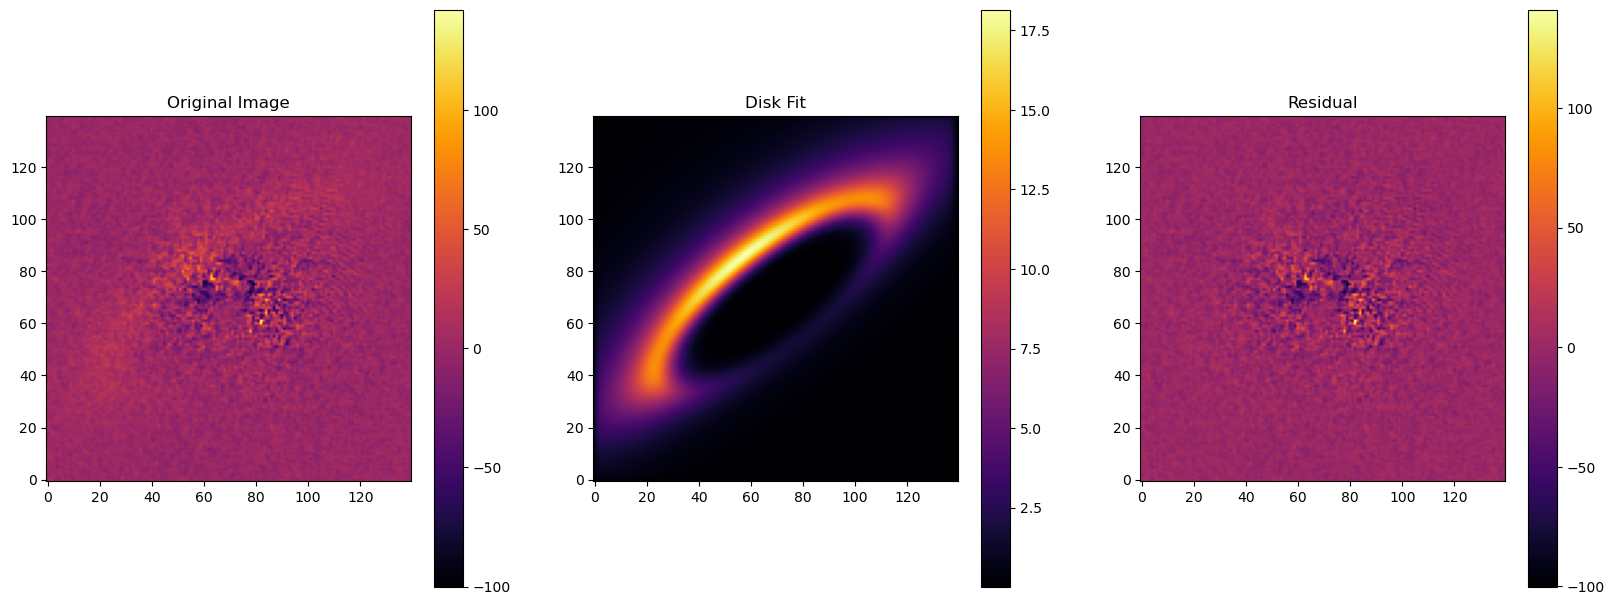

In [7]:
optimal_image = quick_image_cent(soln, PSFModel=GAUSSIAN_PSF, pxInArcsec=0.01414, distance = 70.77)

fig, axes = plt.subplots(1,3, figsize=(20,10))

im = axes[0].imshow(target_image, origin='lower', cmap='inferno')
axes[0].set_title("Original Image")
plt.colorbar(im, ax=axes[0], shrink=0.75)

im = axes[1].imshow(optimal_image, origin='lower', cmap='inferno')
axes[1].set_title("Disk Fit")
plt.colorbar(im, ax=axes[1], shrink=0.75)

im = axes[2].imshow(target_image-optimal_image, origin='lower', cmap='inferno')
axes[2].set_title("Residual")
plt.colorbar(im, ax=axes[2], shrink=0.75)